# 付録

ライブラリの読み込みと関数の定義

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

# 時間応答のグラフを整える関数
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])


## 非線形シミュレーション

### 非線形モデルの記述と時間応答

In [2]:
import control as ct


アームの運動方程式を記述する

In [3]:
# アームの非線形モデル
def arm_model(t, states, inputs, params):
    g = params.get('g', 9.81)
    l = params.get('l', 0.2)
    M = params.get('M', 0.5)
    mu = params.get('mu', 1.5e-2)
    J = params.get('J', 1.0e-2)

    theta, omega = states # 状態変数
    tau = inputs[0] # 入力

    # 非線形状態方程式
    dtheta_dt = omega
    domega_dt = -mu/J*omega - M*g*l/J*np.sin(theta) + (1/J)*tau

    # 線形モデル（原点近傍で近似）
    # domega_dt = -mu/J*omega - M*g*l/J*theta + (1/J)*tau

    return np.array([dtheta_dt, domega_dt])


入出力システムとして定義する

In [4]:
# 入出力システムの記述
arm_sys = ct.NonlinearIOSystem(
    arm_model, None, # 状態方程式と出力方程式を指定
    inputs = ('input'), # 入力の名前
    outputs = ('theta', 'omega'), # 出力の名前
    states = ('theta', 'omega'), # 状態の名前
    name='nonlinear_arm') # システムの名前


入出力システムの時間応答を求める

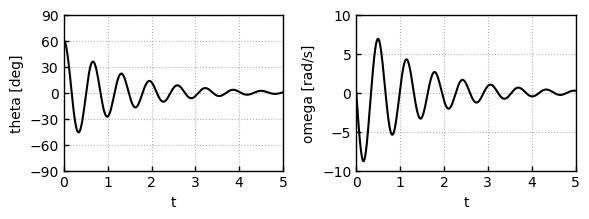

In [5]:
X0 = [np.pi/3, 0] # 初期状態
T = np.arange(0, 5, 0.01) # シミュレーション時間
u = np.zeros_like(T) # 外部入力
# u = 0.7*(T>1)
# u = 0.6*np.sin(10*T)

# 非線形シミュレーション
t, y = ct.input_output_response(arm_sys, T, u, X0)

fig, ax = plt.subplots(1,2, figsize=(6, 2.3))
ax[0].plot(t, np.rad2deg(y[0]), c='k') # アームの角度
ax[1].plot(t, y[1], c='k') # アームの角速度

ax[0].set_xlim([0,5])
ax[1].set_xlim([0,5])
ax[0].set_ylim([-90,90])
ax[0].set_yticks([-90,-60,-30,0,30,60,90])
ax[1].set_ylim([-10,10])

plot_set(ax[0], 't', 'theta [deg]')
plot_set(ax[1], 't', 'omega [rad/s]')

fig.tight_layout()
# fig.savefig("app_nonlinear_simulation.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### 平衡点まわりで線形近似

In [6]:
xeq, ueq = ct.find_eqpt(arm_sys, x0=np.array([np.pi/6,0]), u0=0)
xeq


array([0., 0.])

平衡点まわりの線形近似モデルを求める

In [7]:
# 原点近傍で線形化
lin_arm= ct.linearize(arm_sys, np.array([0,0]), 0)
print(lin_arm)


<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[  0.    1. ]
     [-98.1  -1.5]]

B = [[  0.]
     [100.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]



In [8]:
# x=(pi/4,0)近傍で線形化
# g = 9.81
# l = 0.2
# M = 0.5
# lin_arm= ct.linearize(arm_sys, np.array([np.pi/4,0]), M*g*l/np.sqrt(2))
# print(lin_arm)


非線形モデルと線形モデルの違いをシミュレーションで確認する

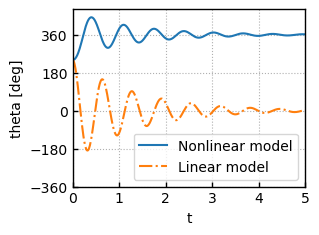

In [9]:
from control.matlab import lsim
X0 = [4*np.pi/3, 0] # 初期状態
T = np.linspace(0, 5, 500) # シミュレーション時間
u = np.zeros_like(T) # 外部入力

# 非線形シミュレーション
t, y = ct.input_output_response(arm_sys, T, u, X0)
# 線形シミュレーション
yl, tl, _ = lsim(lin_arm, u, T, X0)

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, np.rad2deg(y[0]), label='Nonlinear model')
ax.plot(tl, np.rad2deg(yl[:,0]), label='Linear model', ls='-.')

ax.set_xlim([0,5])
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_ylim([-360,480])
ax.set_yticks([-360,-180,0,180,360])
plot_set(ax, 't', 'theta [deg]', 'best')

# fig.savefig("app_nonlinear_vs_linear.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


倒立状態を経由して初期状態に設定し，手を離したときに応答を見ています。

非線形シミュレーションでは，そのまま落下して，垂れ下がった状態（３６０度）になりますが，線形シュミレーションでは一度倒立状態を経由してから垂れ下がった状態（０度）になります。非線形シミュレーションの方が適切な運動になっていることがわかります。

### フィードバック制御系の構築（PD制御）

PD制御器を記述します

In [10]:
def arm_controller(t, states, inputs, params):
    Kp = params.get('Kp', 5.0)
    Kd = params.get('Kd', 0.1)
    theta, omega, theta_ref = inputs
    # 制御則
    u = Kp * (theta_ref - theta) - Kd * omega
    return np.array(u)

io_controller = ct.NonlinearIOSystem(
  None, arm_controller,
  inputs = ('theta', 'omega', 'ref'),
  outputs = ('control_input'), name='controller')


制御対象と制御器のフィードバック結合を求めます

In [11]:
closed_loop_sys = ct.interconnect(
  [arm_sys, io_controller], # 二つのシステムを結合
  connections=[ # 信号の接続
    ['nonlinear_arm.input', 'controller.control_input'],
    ['controller.theta', 'nonlinear_arm.theta'],
    ['controller.omega', 'nonlinear_arm.omega']
  ],
  inplist=['controller.ref'], #結合系の入力
  outlist=['nonlinear_arm.theta', 'nonlinear_arm.omega', 'controller.control_input'] # 結合系の出力
)


比較のために，線形モデルと制御器から構成されるフィードバック制御系を求めておきます

In [12]:
# アームの線形微分方程式
def arm_linear_model(t, states, inputs, params):
    g = params.get('g', 9.81)
    l = params.get('l', 0.2)
    M = params.get('M', 0.5)
    mu = params.get('mu', 1.5e-2)
    J = params.get('J', 1.0e-2)

    # Map the states into local variable names
    theta, omega = states
    tau = inputs[0]

    dtheta_dt = omega
    # 線形モデル（原点近傍で近似）
    domega_dt = -mu/J*omega - M*g*l/J*theta + (1/J)*tau

    return np.array([dtheta_dt, domega_dt])

# IOシステムの記述
arm_linear_sys = ct.NonlinearIOSystem(
    arm_linear_model, None,
    inputs=('input'), outputs=('theta', 'omega'),
    states=('theta', 'omega'), name='linear_arm')

closed_loop_sys_linear = ct.interconnect(
  [arm_linear_sys, io_controller],       # systems
  connections=[
    ['linear_arm.input', 'controller.control_input'],
    ['controller.theta', 'linear_arm.theta'],
    ['controller.omega', 'linear_arm.omega']
  ],
  inplist=['controller.ref'],
  outlist=['linear_arm.theta', 'linear_arm.omega', 'controller.control_input']
)


目標値追従性のシミュレーションをします。

目標値が90度のときは，非線形モデルと線形モデルの応答に差があまりないですが，目標値が180度のときは差が出ています。
これは，モデル化誤差の影響です（sinθ≒θとしているため）。

倒立状態（180度）において，非線形モデルで定常偏差が小さいのは，重力の影響を受けないためです。

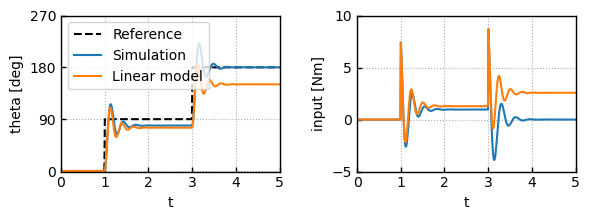

In [13]:
X0 = [0, 0] # 初期状態
r = np.pi/2*(T>1) + np.pi/2*(T>3) # 目標角度

tnl, ynl = ct.input_output_response(closed_loop_sys, T, r, X0)
tl, yl = ct.input_output_response(closed_loop_sys_linear, T, r, X0)

fig, ax = plt.subplots(1,2, figsize=(6, 2.3))
ax[0].plot(T, np.rad2deg(r), label='Reference', ls='--', c='k') # 目標角度
ax[0].plot(tnl, np.rad2deg(ynl[0]), label='Simulation') # アームの角度
ax[0].plot(tl, np.rad2deg(yl[0]), label='Linear model') # アームの角度（線形モデル）
ax[1].plot(tnl, ynl[2]) # トルク
ax[1].plot(tnl, yl[2]) # トルク（線形モデル）

ax[0].set_ylim([-1,270])
ax[0].set_yticks([0, 90, 180, 270])
ax[1].set_ylim([-5,10])

plot_set(ax[0], 't', 'theta [deg]', 'best')
plot_set(ax[1], 't', 'input [Nm]')

fig.tight_layout()
# fig.savefig("app_control_nonlinear_arm.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### おまけ
feedback関数を使う方法。ただし，refを設定できない

In [14]:
def arm_controller(t, states, inputs, params):
    Kp = params.get('Kp', 5.0)
    Kd = params.get('Kd', 0.1)
    theta_ref = params.get('theta_ref', np.deg2rad(180))
    theta, omega = inputs
    # 制御則
    u = Kp * (theta_ref - theta) - Kd * omega
    return np.array(u)

io_controller = ct.NonlinearIOSystem(
  None,
  arm_controller,
  inputs=('theta', 'omega'), outputs=('control_input'), name='controller')


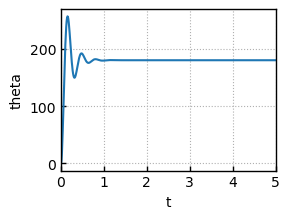

In [15]:
X0 = [0, 0]
T = np.linspace(0, 5, 500)

# Simulate the system

closed_loop_sys = arm_sys.feedback(io_controller, sign=1)
t, y = ct.input_output_response(closed_loop_sys, T, 0, X0)

# Plot the response
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, np.rad2deg(y[0]))

plot_set(ax, 't', 'theta')

fig.tight_layout()
#fig.savefig("res_ss_sin.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


PD制御器の書き方を変える。偏差r-yをinterconnect関数の中で記述する

In [16]:
def arm_controller2(t, states, inputs, params):
    Kp = params.get('Kp', 5.0)
    Kd = params.get('Kd', 0.1)
    error, omega = inputs
    # u = Kp * (theta_ref - theta) - Kd * omega
    u = Kp * error - Kd * omega
    return np.array(u)


In [17]:
io_controller2 = ct.NonlinearIOSystem(
  None,
  arm_controller2,
  inputs=('error', 'omega'), outputs=('control_input'), name='controller')


In [18]:
closed_loop_sys2 = ct.interconnect(
  [arm_sys, io_controller2],       # systems
  connections=[
    ['nonlinear_arm.input', 'controller.control_input'],
    ['controller.error', '-nonlinear_arm.theta'], #error に -theta を加える
    ['controller.omega', 'nonlinear_arm.omega']
  ],
  inplist=['controller.error'],
  outlist=['nonlinear_arm.theta', 'nonlinear_arm.omega', 'controller.control_input']
)


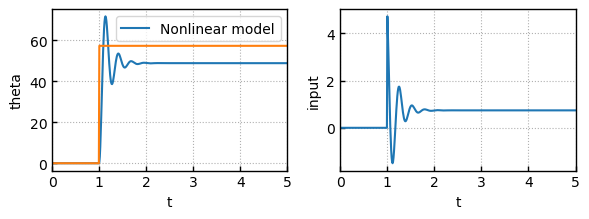

In [19]:
# Simulate the system
X0 = [0, 0]
u = 1*(T>1)
tnl, ynl = ct.input_output_response(closed_loop_sys2, T, u, X0)

# Plot the response
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))
ax[0].plot(tnl, np.rad2deg(ynl[0]), label='Nonlinear model')
ax[0].plot(T, np.rad2deg(u))
ax[1].plot(tnl, ynl[2])

plot_set(ax[0], 't', 'theta', 'best')
plot_set(ax[1], 't', 'input')

fig.tight_layout()
